<a href="https://colab.research.google.com/github/leadeeerq/Projects/blob/main/221211_Projekt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
Sentiment analysis of the Top 50 rap songs over last years


---



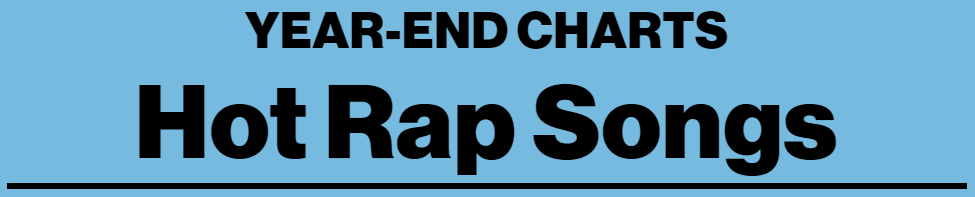

Zmiany 07.12.2022
* rozdzielenie funkcji scraping na scraping_to_dict (obsolete) i scraping_to_list, aby nie zagnieżdżać słownika: rok: artrysta: tytuł -> rok: artysta tytuł
* scraping z google - działa, ale należy rozszerzyć wynik (kliknięcie "pełny tekst")
* policzona częstotliwość występowania słów w dict_2013
---
- naprawić stop_words (głównie apostrofy)
- pełny tekst piosenek z google - OK
- do chmury słów wybrać tylko rzeczowniki i ew. czasowniki!

Zmiany 08.12.2022
* Import selenium do kliknięcia na przycisk "Full lyrics" (jeśl występuje) - edycja funkcji scraping_google (z warunkiem na wystąpienie przycisku)

Zmiany 11.12.2022
* Scrapowanie googla przez PyCharm - dict zapisany jako pickle, który należy zaimporować do colaba

#Libraries

In [151]:
from bs4 import BeautifulSoup as bs
import requests
import pickle
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob, Word
import time

In [ ]:
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('brown')

#Scraping the billboard

##Loading the webpage (2013)

In [52]:
r = requests.get('https://www.billboard.com/charts/year-end/2013/hot-rap-songs/')

##Converting to the beautiful soup object

In [53]:
soup = bs(r.content, 'html.parser')

##Printing out the HTML code

In [54]:
contents = soup.prettify()
print(contents[:100])

<!DOCTYPE html>
<!--[if IE 6]>
<html id="ie6" lang="en-US">
<![endif]-->
<!--[if IE 7]>
<html id="ie


##Finding the tags

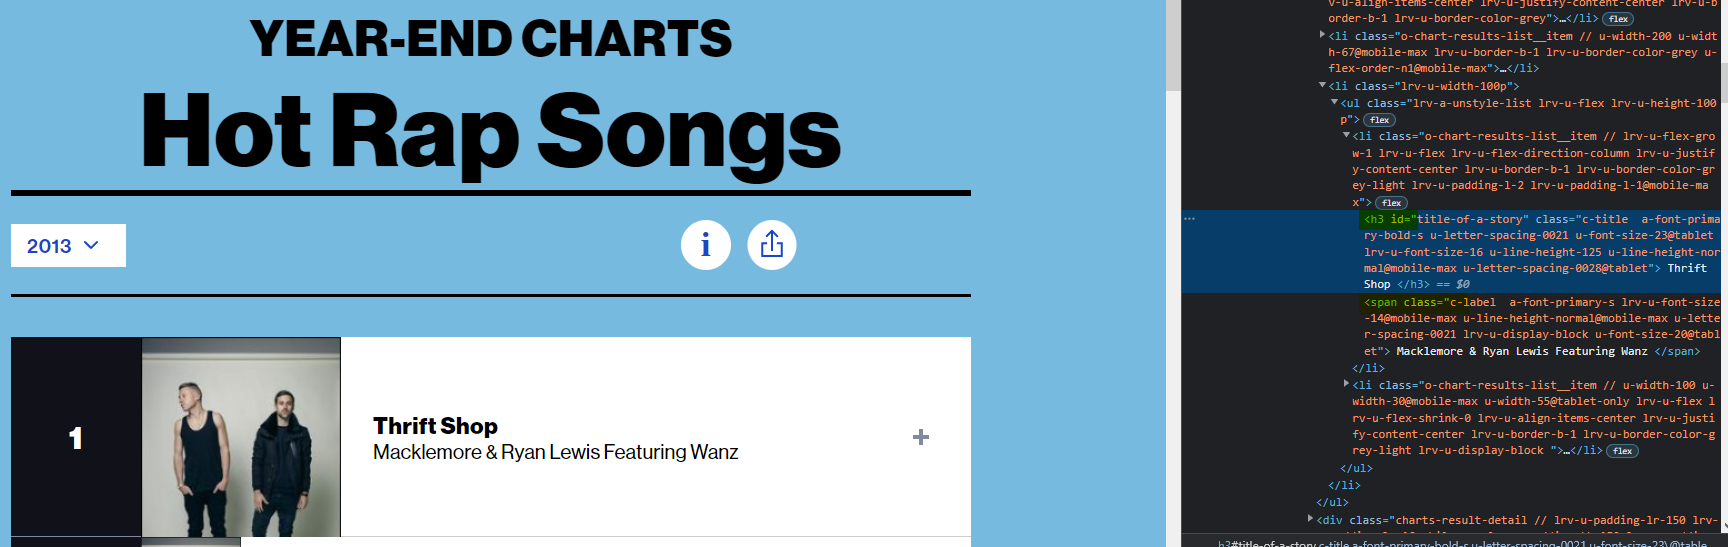

##Titles of the songs

In [78]:
titles = []

for h3_tag in soup.find_all('h3')[:50]:
    titles.append(h3_tag.get_text(' ', strip = True))
    # print(h3_tag.get_text(' ', strip = True)) 

In [69]:
titles[:3]

['Thrift Shop', "Can't Hold Us", 'Holy Grail']

##Artists

In [79]:
artists = []

div_tag = soup.find('div', {'class': 'chart-results-list // u-padding-b-250'})
for li_tag in div_tag.find_all('li', {'class': 'lrv-u-width-100p'}):
  for span_tag in li_tag.find_all('span'):
    artists.append(span_tag.get_text(' ', strip = True))
    # print(span_tag.get_text(' ', strip = True))

In [70]:
artists[:3]

['Macklemore & Ryan Lewis Featuring Wanz',
 'Macklemore & Ryan Lewis Featuring Ray Dalton',
 'Jay Z Featuring Justin Timberlake']

##Dict of artists and their songs

In [80]:
songs_2013 = {}

for artist in artists:
  for song in titles:
    songs_2013[artist] = song
    # titles.remove(song)
    # break

In [85]:
list(songs_2013.items())[:3]

[('Macklemore & Ryan Lewis Featuring Wanz', 'Pop That'),
 ('Macklemore & Ryan Lewis Featuring Ray Dalton', 'Pop That'),
 ('Jay Z Featuring Justin Timberlake', 'Pop That')]

#Scraping function

##Definition of the function

In [86]:
def scraping_to_dict(url):
  r = requests.get(url)
  soup = bs(r.content)

  titles = []
  artists = []
  songs_dict = {}

  for h3_tag in soup.find_all('h3')[:50]:
    titles.append(h3_tag.get_text(' ', strip = True))

  div_tag = soup.find('div', {'class': 'chart-results-list // u-padding-b-250'})
  for li_tag in div_tag.find_all('li', {'class': 'lrv-u-width-100p'}):
    for span_tag in li_tag.find_all('span'):
      artists.append(span_tag.get_text(' ', strip = True))

  for artist in artists:
    for song in titles:
      songs_dict[artist] = song
      titles.remove(song)
      break

  return songs_dict

In [87]:
def scraping_to_list(url):
  r = requests.get(url)
  soup = bs(r.content)

  titles = []
  artists = []
  songs_list = []

  #Titles
  for h3_tag in soup.find_all('h3')[:50]:
    titles.append(h3_tag.get_text(' ', strip = True))

  #Artists
  div_tag = soup.find('div', {'class': 'chart-results-list // u-padding-b-250'})
  for li_tag in div_tag.find_all('li', {'class': 'lrv-u-width-100p'}):
    for span_tag in li_tag.find_all('span'):
      artists.append(span_tag.get_text(' ', strip = True))

  songs_list = [x + ' ' + y for x, y in zip(artists, titles)]

  return songs_list

In [ ]:
# songs_2014 = scraping_to_list('https://www.billboard.com/charts/year-end/2014/hot-rap-songs/')
# songs_2014

##List of urls

In [88]:
years = list(range(2013, 2023, 1))

base_url = 'https://www.billboard.com/charts/year-end/' #+year + end_url
end_url = '/hot-rap-songs/'

list_of_urls = []

for year in years:
  url = str(base_url + str(year) + end_url)
  list_of_urls.append(url)

In [89]:
list_of_urls

['https://www.billboard.com/charts/year-end/2013/hot-rap-songs/',
 'https://www.billboard.com/charts/year-end/2014/hot-rap-songs/',
 'https://www.billboard.com/charts/year-end/2015/hot-rap-songs/',
 'https://www.billboard.com/charts/year-end/2016/hot-rap-songs/',
 'https://www.billboard.com/charts/year-end/2017/hot-rap-songs/',
 'https://www.billboard.com/charts/year-end/2018/hot-rap-songs/',
 'https://www.billboard.com/charts/year-end/2019/hot-rap-songs/',
 'https://www.billboard.com/charts/year-end/2020/hot-rap-songs/',
 'https://www.billboard.com/charts/year-end/2021/hot-rap-songs/',
 'https://www.billboard.com/charts/year-end/2022/hot-rap-songs/']

##Dict of songs of the last 9 years

In [90]:
dict_of_years = {}

for i in range(len(list_of_urls)):
  for year in years:
    dict_of_years[year] = scraping_to_dict(list_of_urls[i])
    # dict_of_years[year] = scraping_to_list(list_of_urls[i])

In [112]:
songs_dict = {}
songs = {}

for year in years:
    songs_dict[year] = scraping_to_dict(list_of_urls[year - 2013])
    songs[year] = scraping_to_list(list_of_urls[year - 2013])

In [113]:
list(songs.items())[-1]

(2022,
 ['Jack Harlow First Class',
  'Future Featuring Drake & Tems Wait For U',
  'Latto Big Energy',
  'Kodak Black Super Gremlin',
  'Lil Nas X & Jack Harlow Industry Baby',
  'Drake Featuring 21 Savage Jimmy Cooks',
  'Doja Cat Vegas',
  'Lil Baby In A Minute',
  'Gunna & Future Featuring Young Thug Pushin P',
  'Megan Thee Stallion & Dua Lipa Sweetest Pie',
  'Nicki Minaj Super Freaky Girl',
  'Drake Featuring 21 Savage & Project Pat Knife Talk',
  'Drake Featuring Future & Young Thug Way 2 Sexy',
  'Lil Durk Featuring Morgan Wallen Broadway Girls',
  'Lil Durk Featuring Gunna What Happened To Virgil',
  'Future Puffin On Zootiez',
  'Drake Featuring Lil Baby Girls Want Girls',
  'JNR CHOI & Sam Tompkins To The Moon!',
  'Drake Sticky',
  'Nardo Wick Featuring G Herbo, Lil Durk & 21 Savage Who Want Smoke??',
  'Yung Gravy Betty (Get Money)',
  'Post Malone Featuring Roddy Ricch Cooped Up',
  "Hitkidd & GloRilla F.N.F. (Let's Go)",
  'DJ Khaled Featuring Drake & Lil Baby Staying A

##Saving a dict with the pickle

In [100]:
def to_pickle(file, filename):
  base_url = '/content/drive/MyDrive/Projekty/PROJEKT/'
  with open (base_url+filename, 'wb') as handle:
    pickle.dump(file, handle, protocol = pickle.HIGHEST_PROTOCOL)

In [114]:
#Pickling the dict where key is the year and value is the list with songs
to_pickle(songs, 'songs.pickle')

In [ ]:
#Pickling the dict where key is the year and value is the dict with artist:song
# to_pickle(songs_dict, 'songs_dict.pickle')

In [115]:
with open('/content/drive/MyDrive/Projekty/PROJEKT/songs.pickle', 'rb') as handle:
  songs = pickle.load(handle)

#Handling a specific year

In [116]:
#Show songs from year 2013
songs[2022]

['Jack Harlow First Class',
 'Future Featuring Drake & Tems Wait For U',
 'Latto Big Energy',
 'Kodak Black Super Gremlin',
 'Lil Nas X & Jack Harlow Industry Baby',
 'Drake Featuring 21 Savage Jimmy Cooks',
 'Doja Cat Vegas',
 'Lil Baby In A Minute',
 'Gunna & Future Featuring Young Thug Pushin P',
 'Megan Thee Stallion & Dua Lipa Sweetest Pie',
 'Nicki Minaj Super Freaky Girl',
 'Drake Featuring 21 Savage & Project Pat Knife Talk',
 'Drake Featuring Future & Young Thug Way 2 Sexy',
 'Lil Durk Featuring Morgan Wallen Broadway Girls',
 'Lil Durk Featuring Gunna What Happened To Virgil',
 'Future Puffin On Zootiez',
 'Drake Featuring Lil Baby Girls Want Girls',
 'JNR CHOI & Sam Tompkins To The Moon!',
 'Drake Sticky',
 'Nardo Wick Featuring G Herbo, Lil Durk & 21 Savage Who Want Smoke??',
 'Yung Gravy Betty (Get Money)',
 'Post Malone Featuring Roddy Ricch Cooped Up',
 "Hitkidd & GloRilla F.N.F. (Let's Go)",
 'DJ Khaled Featuring Drake & Lil Baby Staying Alive',
 'SleazyWorld Go Featuri

In [117]:
print(len(songs[2022]))

50


In [118]:
#Dict_dict_of_years
# first_song = list(dict_dict_of_years[2013].items())[0]

#Dict_list_of_years
first_song = songs[2022][0]
first_song

'Jack Harlow First Class'

In [ ]:
#Necessary if dict_dict_of_years was used
# def tuple_to_str(row):
#   str = ' '.join(row)
#   return str

# first_song = tuple_to_str(first_song)
# first_song

###Exporting songs list to a pickle file to process it with PyCharm

In [119]:
to_pickle(songs[2013], 'songs_2013.pickle')

In [120]:
for year in years:
  to_pickle(songs[year], f'songs_{year}.pickle')

##Lyrics from google - need to unwind entire lyrics :(

In [121]:
def scraping_google(text):
  base_url = 'https://google.com/search?q='
  url = base_url + str(text) + 'lyrics'
  # url = text
  # http://myhttpheader.com #to get the header, mine is for opera
  headers = {
      'User-agent':
      'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/107.0.0.0 Safari/537.36 OPR/93.0.0.0'
  }
  r = requests.get(url, headers = headers)
  soup = bs(r.content)
  div_tags = soup.find_all('div', {'class': 'xaAUmb'})
  lyrics = []

  for div_tag in div_tags:
    lyrics.append(div_tag.get_text(' ', strip = True))

  # print(lyrics) #for debugging
  return(lyrics)

In [122]:
print(songs[2013][5])

A$AP Rocky Featuring Drake, 2 Chainz & Kendrick Lamar F**kin Problems


In [123]:
scraping_google(songs[2013][5])

["I love bad bitches that's my fuckin problem And yeah I like to fuck I got a fuckin problem I love bad bitches that's my fuckin problem And yeah I like to fuck I got a fuckin problem … Full lyrics"]

##Dict of year of 2013 with lyrics

In [124]:
dict_2013 = {}
keys = songs[2013]

for i in range(len(songs[2013])):
  dict_2013[keys[i]] = scraping_google(songs[2013][i])

In [ ]:
to_pickle(dict_2013, 'dict_2013.pickle')

In [ ]:
dict_2013

#Natural Language Processing

---

##Loading the pickle created with PyCharm (dict of songs) to combine all lyrics in one list
---

In [130]:
with open('/content/drive/MyDrive/Projekty/PROJEKT/PyCharm_songs_2013.pickle', 'rb') as handle:
  songs_2013 = pickle.load(handle)

In [ ]:
list(songs_2013.values())

In [ ]:
list_of_words_2013 = ''.join(str(list(songs_2013.values())))
list_of_words_2013

##Removing special characters

In [138]:
#Removing characters: [],"\ etc.
list_of_words_2013 = list_of_words_2013.translate({ord(i): None for i in '[],".\\()!?…'})
list_of_words_2013 = list_of_words_2013.replace("'", "",)
list_of_words_2013 = list_of_words_2013.replace("Coś się nie udało Spróbuj jeszcze raz Przetłumacz na: polski", " ")

##Uppercase to lowercase

In [141]:
list_of_words_2013 = list_of_words_2013.lower()

##Removing stopwords

In [142]:
stop_words = STOPWORDS #Removing unnecessary words
stop_words.update(["you'd", "i'd", "'ll", "'til", "'s", "ca n't", "n't", "'m", "'re", "y'all"])

print(stop_words)

{'because', 'from', 'those', 'there', 'few', 'further', 'until', 'against', 'does', 'itself', 'we', 'after', "there's", 'between', 'each', 'have', 'whom', "she'd", "didn't", 'no', 'why', 'your', "when's", 'through', 'our', 'can', "he'll", 'hence', 'too', "he'd", 'during', "she's", 'also', 'with', 'its', 'all', 'that', 'you', 'them', 'it', 'since', 'like', "they'll", 'yours', "can't", 'therefore', 'which', 'off', "mustn't", "isn't", 'than', 'however', "who's", 'such', 'by', 'into', 'she', 'under', "couldn't", 'am', "she'll", 'ourselves', 'her', "where's", 'do', 'most', "they've", 'r', 'ought', 'only', "we'd", 'being', 'had', "wouldn't", 'should', 'myself', 'as', "ca n't", 'here', "i'd", "that's", "doesn't", "'re", 'my', 'about', 'for', "we're", 'were', 'up', "we'll", 'yourself', 'same', 'herself', 'would', 'so', 'did', 'while', "why's", 'how', "let's", 'cannot', 'otherwise', 'i', 'where', 'both', 'then', "they're", "here's", "shouldn't", 'if', 'is', "'m", "he's", 'this', 'other', 'an', 

In [143]:
words = word_tokenize(list_of_words_2013)
stripped_words = []
for word in words:
  if word not in stop_words:
    stripped_words.append(word)

print(" ".join(stripped_words))

stripped_words_str = " ".join(stripped_words)

hey macklemore go thrift shopping bada bada bada doo da bada bada bada doo da bada bada bada doo da bada bada bada doo da oh oh bada bada bada doo da bada bada bada doo da ow im gon na pop tags got twenty dollars pocket im hunting looking come-up fucking awesome nah walk club got big cock im pumped bought shit thrift shop oh ice fringe damn frosty people damn thats cold ass honkey rollin hella deep headin mezzanine dressed pink cept gator shoes green draped leopard mink girls standin next probably shoulda washed smells kellys sheets piss shit ninety-nine cents bag coppin washin bout go compliments passin moccasins someone elses walkin bummy grungy fuck man stuntin flossin savin money im hella happy thats bargain bitch ima take grandpas style ima take grandpas style real ask grandpa hand-me-downs thank velour jumpsuit house slippers dookie brown leather jacket found diggin broken keyboard bought broken keyboard bought skeet blanket bought kneeboard hello hello ace man mellow john wayne 

##Spell correction (TextBlob)

In [155]:
corrected_words_str = TextBlob(stripped_words_str)
corrected_words_str = corrected_words_str.correct()

In [157]:
corrected_words_str.sentiment

Sentiment(polarity=-5.7910384511129506e-05, subjectivity=0.5094516631484827)

##Noun pharases

In [ ]:
corrected_words_str.noun_phrases

##Lemmatization

In [169]:
lemmatized_words = TextBlob(str(corrected_words_str))
lemmatized_words = " ". join([w.lemmatize() for w in lemmatized_words.words])

In [173]:
lemmatized_words = lemmatized_words.split()

In [178]:
corrected_words_str == lemmatized_words

False

---
##Words processing function
---

In [194]:
def words_processing(pickled_list):
  list_of_words = ''.join(str(list(pickled_list.values())))
  #Removing special characters and removing phrase with polish words (last paragraph)
  list_of_words = list_of_words.translate({ord(i): None for i in '[],".\\()!?…'})
  list_of_words = list_of_words.replace("'", "",)
  list_of_words = list_of_words.replace("Coś się nie udało Spróbuj jeszcze raz Przetłumacz na: polski", " ")

  #Changing all to lowercase
  list_of_words = list_of_words.lower()

  #Removing stopwords
  stop_words = STOPWORDS #Removing necessary words
  stop_words.update(["you'd", "i'd", "'ll", "'til", "'s", "ca n't", "n't", "'m", "'re", "y'all"])
  words = word_tokenize(list_of_words)
  stripped_words = []
  for word in words:
    if word not in stop_words:
      stripped_words.append(word)
  stripped_words_str = " ".join(stripped_words)

  #Spell correction with TextBlob / optionally
  # corrected_words = TextBlob(stripped_words_str)
  # corrected_words = corrected_words.correct()

  #Lemmatization
  lemmatized_words = TextBlob(str(stripped_words_str))
  lemmatized_words = " ". join([w.lemmatize() for w in lemmatized_words.words])
  lemmatized_words = lemmatized_words.split() #Back to list

  return lemmatized_words

In [197]:
with open('/content/drive/MyDrive/Projekty/PROJEKT/PyCharm_songs_2014.pickle', 'rb') as handle:
  songs_2014 = pickle.load(handle)

In [ ]:
words_2014 = words_processing(songs_2014)
words_2014

##Count frequency of words

In [175]:
def count(word):
  # Check if the '.' is the last character of the word, if so, igore it
  if word[-1] == '.':
      word = word[0:len(word) - 1]
  # If the word already exists in dict, increment the value
  if word in dictionary:
      dictionary[word] += 1
  # If the word doesn't apprear in the dict, create the key and assign value of 1
  else:
      dictionary.update({word: 1})

In [199]:
dictionary = {}

for word in words_2014:
    count(word)
 
for all_words in dictionary:
  if dictionary[all_words] >= 100:
    print ("Frequency of", all_words, end = " ")
    print (":", end = " ")
    print (dictionary[all_words], end = " ")
    print()

Frequency of im : 444 
Frequency of still : 128 
Frequency of bitch : 137 
Frequency of know : 217 
Frequency of la : 153 
Frequency of baby : 120 
Frequency of got : 245 
Frequency of now : 114 
Frequency of dont : 203 
Frequency of love : 198 
Frequency of aint : 154 
Frequency of shit : 116 
Frequency of nigga : 263 
Frequency of hol : 142 


In [200]:
dict(sorted(dictionary.items(), key=lambda item: item[1], reverse=True))

{'im': 444,
 'nigga': 263,
 'got': 245,
 'know': 217,
 'dont': 203,
 'love': 198,
 'aint': 154,
 'la': 153,
 'hol': 142,
 'bitch': 137,
 'still': 128,
 'baby': 120,
 'shit': 116,
 'now': 114,
 'girl': 99,
 'hitta': 92,
 'cause': 90,
 'fuck': 86,
 'one': 85,
 'yeah': 81,
 'thats': 79,
 'na': 78,
 'back': 77,
 'go': 76,
 'make': 71,
 'man': 69,
 'want': 67,
 'youre': 66,
 'em': 65,
 'let': 64,
 'money': 63,
 'say': 62,
 'cant': 59,
 'see': 59,
 'ill': 56,
 'night': 55,
 'real': 55,
 'never': 53,
 'take': 53,
 'uh': 53,
 'right': 52,
 'gon': 52,
 'wan': 50,
 'feel': 48,
 'time': 47,
 'better': 47,
 'said': 46,
 'hoe': 46,
 'way': 45,
 'walk': 45,
 'mediocre': 45,
 'tell': 44,
 'look': 44,
 'hit': 44,
 'day': 44,
 'every': 44,
 'come': 44,
 'work': 43,
 'j': 43,
 'tryna': 42,
 'pas': 42,
 'think': 41,
 'saying': 41,
 'watch': 41,
 'give': 40,
 'ta': 39,
 'boy': 39,
 'ima': 39,
 'trophy': 39,
 'put': 38,
 'wild': 38,
 'came': 38,
 'stoner': 38,
 'need': 37,
 'even': 37,
 'bring': 36,
 'oh':